<a href="https://colab.research.google.com/github/Vijendra07Kulhade/DS_Projects/blob/master/Vijendra_Kulhade_VolcanoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install joblib==1.3
!pip install pycaret
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.9/301.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.0
    Uninstalling joblib-1.4.0:
      Successfully uninstalled joblib-1.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 75.5 MB/s eta 0:0

In [2]:
import pycaret
print(pycaret.__version__)
# from pycaret.utils import enable_colab
# enable_colab()

3.3.1


In [3]:
from pycaret.regression import *
import pandas as pd
import numpy as np
import os

# Loading the data
Since the data is available in Text File, Loading Data into 2 parts.


1.   In First Part there are details about Volcano, which has been loaded into separate dataframe.
2.   Second part of the Observation Text file contains pressure details at each time stamp, this will be used for regression model.

Above loaded data will be used for
1. Accurately estimates the remaining time units until eruption for a given observation from Volcano
2. To estimate the magnitude of the impending volcanic eruption, Estimate the tilt erupt value, which represents the last sensor reading corresponding to the moment of eruption. This particular value exhibits a strong correlation with the magnitude of the eruption.

Model Selection will done based on
1. Akeike Information Criterian (AIC)
2. Bayesian Information Criterian (BIC)





In [4]:
prefix = '/content/drive/MyDrive/datasets/Volcano_Dataset'

# Iterate through the directory tree using os.walk()
final_df_sensor = pd.DataFrame()
final_df_time = pd.DataFrame()
count=0
for root, dirs, files in os.walk(prefix):
    # if count==2:
    #   break
    for file in files:
      # print(os.path.join(root, file)[48:].replace('/','_')[:-4])
      df_sensor = pd.read_csv(os.path.join(root, file),
                       skip_blank_lines=True,on_bad_lines='skip').T
      df_sensor.columns = df_sensor.iloc[0]
      df_sensor = df_sensor[1:]
      df_sensor['VOL_ID'] = os.path.join(root, file)[48:].replace('/','_')[:-4]
      final_df_sensor = pd.concat([final_df_sensor,df_sensor],axis=0)

      df_time = pd.read_csv(os.path.join(root, file),
                       skiprows=range(14),
                       skip_blank_lines=True,header=None).T
      df_time.columns = ['ts','pressure']
      df_time['VOL_ID'] = os.path.join(root, file)[48:].replace('/','_')[:-4]
      final_df_time = pd.concat([final_df_time,df_time], axis=0)

    count+=1

print(final_df_time.shape)

(242827, 3)


# Data Analysis
Visualizing pressure at volcano before erruption

In [5]:
vol_grp = final_df_time.groupby('VOL_ID')

In [6]:
import random
random.seed(1332)
def random_groups(grouped_df,k=10):
  return random.sample(grouped_df.groups.keys(),k)
random_grp_names = random_groups(vol_grp)
len(random_grp_names)

10

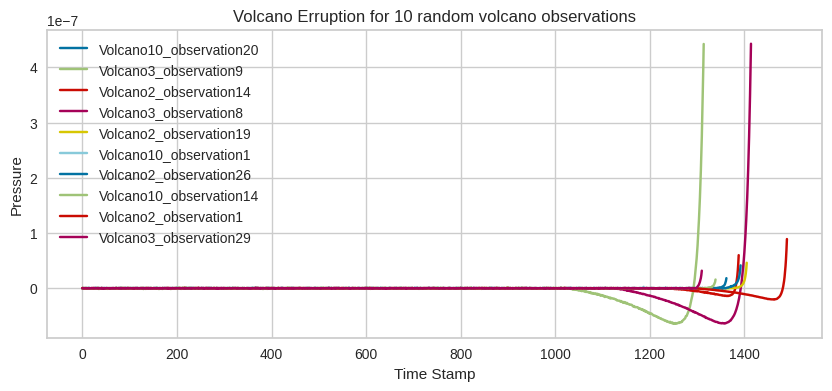

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
vol_grp = final_df_time.groupby('VOL_ID')
labels = []
for grp in random_grp_names:
  label, = ax.plot(vol_grp.get_group(grp)['pressure'], label=grp)
  ax.legend(loc='upper left', fontsize=10)

plt.title('Volcano Erruption for 10 random volcano observations')
ax.set_xlabel('Time Stamp')
ax.set_ylabel('Pressure')
plt.show()

1. It appears there are some volcanos which errupts way faster than others, They represents a sensitive graographical location.
2. Also Change pattern is looks linear for initial time stamps, however it becomes non linear when close to eruption.



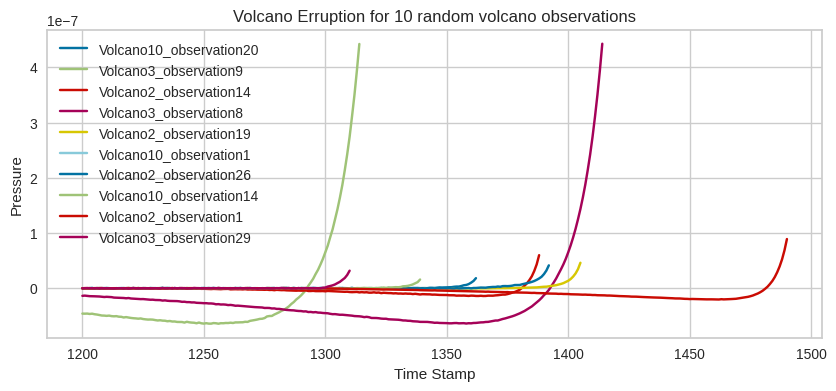

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
for grp in random_grp_names:
  label, = ax.plot(vol_grp.get_group(grp)['pressure'][1200:], label=grp)
  ax.legend(loc='upper left', fontsize=10)

plt.title('Volcano Erruption for 10 random volcano observations')
ax.set_xlabel('Time Stamp')
ax.set_ylabel('Pressure')
plt.show()

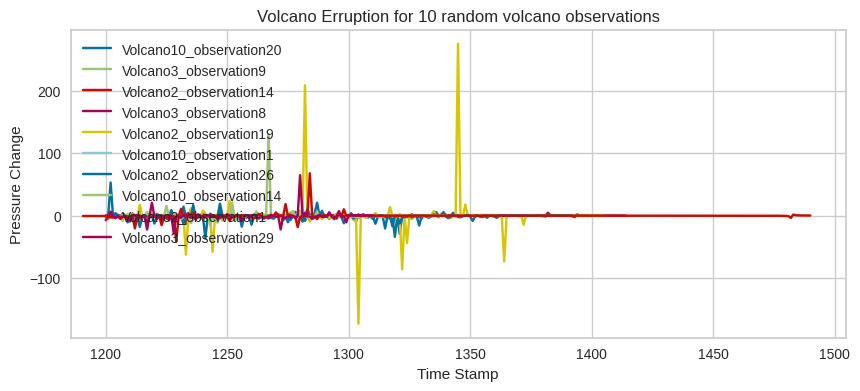

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
for grp in random_grp_names:
  label, = ax.plot(vol_grp.get_group(grp)['pressure'].pct_change()[1200:], label=grp)
  ax.legend(loc='upper left', fontsize=10)

plt.title('Volcano Erruption for 10 random volcano observations')
ax.set_xlabel('Time Stamp')
ax.set_ylabel('Pressure Change')
plt.show()

In [10]:
final_df_sensor

v,Patm,g,r,G,rho,mu,rc,M,sigma,tilt_erupt,VOL_ID
0.25,100000,9.81,500,10^11.27,2300,10^4.22,26,10^5.83,0.25,1.0748nrad,Volcano7_observation2
0.25,100000,9.81,500,10^11.27,2300,10^4.22,26,10^5.83,0.5,1.0748nrad,Volcano7_observation3
0.25,100000,9.81,500,10^11.27,2300,10^4.22,26,10^6.25,0.1,2.5173nrad,Volcano7_observation4
0.25,100000,9.81,500,10^11.27,2300,10^4.22,26,10^6.25,0.5,2.5173nrad,Volcano7_observation6
0.25,100000,9.81,500,10^11.27,2300,10^4.22,26,10^6.25,0.25,2.5173nrad,Volcano7_observation5
...,...,...,...,...,...,...,...,...,...,...,...
0.25,100000,9.81,500,10^11.44,2400,10^4.55,15,10^5.91,0.25,1.2045nrad,Volcano9_observation8
0.25,100000,9.81,500,10^11.44,2400,10^4.55,15,10^5.91,0.5,1.2045nrad,Volcano9_observation9
0.25,100000,9.81,500,10^11.44,2400,10^4.55,15,10^6.12,0.1,1.5821nrad,Volcano9_observation10
0.25,100000,9.81,500,10^11.44,2400,10^4.55,15,10^6.12,0.25,1.5821nrad,Volcano9_observation11


Sensor readings other than pressure looks similar for most of the Volcanos as shown above.

# Preparing Training and Testing data for
1. Predicting remaining time for erruption. Splitting given timely pressure data into 100 time stamps and capturing the final time of erruption for that Volcano observation. This will capture the relation between pressure to time of erruption.
  * In this dataset we can take the rate of change, moving average of pressure, average pressure, min and max pressure as features.
  * Also we can take Moving Averages at different windows to increase the features

2. Predicting pressure at the time of tilt erruption is a time series prediction task. Preparing data into window of 500 readings, where the 501th reading will be the label for prediction. Since pycaret does its own data setup.
This approach might not be applicable for pycaret. But we can use it for neural nerwork based model.

In [11]:
final_df_time['pct_change_10'] = vol_grp['pressure'].pct_change(periods=10)
final_df_time['time_to_erupt'] = 0-final_df_time['ts']
# Simple Moving Average
final_df_time['SMA_10'] = vol_grp['pressure'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
final_df_time['SMA_50'] = vol_grp['pressure'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
# Cumulative Moving Average
final_df_time['CMA_MEAN'] = vol_grp['pressure'].transform(lambda x: x.expanding(min_periods=1).mean())
final_df_time['CMA_MIN'] = vol_grp['pressure'].transform(lambda x: x.expanding(min_periods=1).min())
final_df_time['CMA_MAX'] = vol_grp['pressure'].transform(lambda x: x.expanding(min_periods=1).max())
# Exponential Moving Average
final_df_time['EMA_10'] = vol_grp['pressure'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
final_df_time['EMA_50'] = vol_grp['pressure'].transform(lambda x: x.ewm(span=10, adjust=False).mean())
final_df_time

,ts,pressure,VOL_ID,pct_change_10,time_to_erupt,SMA_10,SMA_50,CMA_MEAN,CMA_MIN,CMA_MAX,EMA_10,EMA_50
0,-1130.0,-2.193983e-10,Volcano7_observation2,NaN,1130.0,-2.193983e-10,-2.193983e-10,-2.193983e-10,-2.193983e-10,-2.193983e-10,-2.193983e-10,-2.193983e-10
1,-1129.0,8.015715e-11,Volcano7_observation2,NaN,1129.0,-6.962056e-11,-6.962056e-11,-6.962056e-11,-2.193983e-10,8.015715e-11,-1.649337e-10,-1.649337e-10
2,-1128.0,-9.290056e-11,Volcano7_observation2,NaN,1128.0,-7.738056e-11,-7.738056e-11,-7.738056e-11,-2.193983e-10,8.015715e-11,-1.518367e-10,-1.518367e-10
3,-1127.0,9.809553e-11,Volcano7_observation2,NaN,1127.0,-3.351154e-11,-3.351154e-11,-3.351154e-11,-2.193983e-10,9.809553e-11,-1.063945e-10,-1.063945e-10
4,-1126.0,2.490433e-10,Volcano7_observation2,NaN,1126.0,2.299942e-11,2.299942e-11,2.299942e-11,-2.193983e-10,2.490433e-10,-4.176945e-11,-4.176945e-11
...,...,...,...,...,...,...,...,...,...,...,...,...
1046,-4.0,1.697631e-09,Volcano9_observation12,0.507433,4.0,1.213702e-09,5.052030e-10,-2.035442e-11,-1.563362e-09,2.218001e-09,1.300162e-09,1.300162e-09
1047,-3.0,8.307329e-10,Volcano9_observation12,-0.130804,3.0,1.201200e-09,5.199712e-10,-1.954232e-11,-1.563362e-09,2.218001e-09,1.214811e-09,1.214811e-09
1048,-2.0,9.932948e-10,Volcano9_observation12,2.298179,2.0,1.270413e-09,5.566051e-10,-1.857679e-11,-1.563362e-09,2.218001e-09,1.174536e-09,1.174536e-09
1049,-1.0,2.297608e-09,Volcano9_observation12,0.842626,1.0,1.375482e-09,5.873238e-10,-1.637090e-11,-1.563362e-09,2.297608e-09,1.378731e-09,1.378731e-09


In [12]:
final_df_time.isna().sum()

ts                  0
pressure            0
VOL_ID              0
pct_change_10    1890
time_to_erupt       0
SMA_10              0
SMA_50              0
CMA_MEAN            0
CMA_MIN             0
CMA_MAX             0
EMA_10              0
EMA_50              0
dtype: int64

In [13]:
final_df_time.dropna(axis=0,inplace=True)

In [14]:
train_volcanos = random.sample(vol_grp.groups.keys(),k=150)
grouped_df = final_df_time.groupby('VOL_ID')
training_data = pd.concat([grouped_df.get_group(x) for x in train_volcanos], axis=0)
training_data

,ts,pressure,VOL_ID,pct_change_10,time_to_erupt,SMA_10,SMA_50,CMA_MEAN,CMA_MIN,CMA_MAX,EMA_10,EMA_50
10,-1464.0,-2.585241e-10,Volcano3_observation30,-0.525131,1464.0,4.626893e-11,-7.429257e-12,-7.429257e-12,-6.520666e-10,6.490307e-10,-2.058296e-11,-2.058296e-11
11,-1463.0,3.703463e-10,Volcano3_observation30,0.828970,1463.0,6.305466e-11,2.405204e-11,2.405204e-11,-6.520666e-10,6.490307e-10,5.049508e-11,5.049508e-11
12,-1462.0,1.950074e-11,Volcano3_observation30,-0.944882,1462.0,2.962450e-11,2.370194e-11,2.370194e-11,-6.520666e-10,6.490307e-10,4.485975e-11,4.485975e-11
13,-1461.0,-2.602725e-10,Volcano3_observation30,-0.600850,1461.0,6.880391e-11,3.418052e-12,3.418052e-12,-6.520666e-10,6.490307e-10,-1.061884e-11,-1.061884e-11
14,-1460.0,-6.065888e-10,Volcano3_observation30,1.646952,1460.0,3.106153e-11,-3.724907e-11,-3.724907e-11,-6.520666e-10,6.490307e-10,-1.189770e-10,-1.189770e-10
...,...,...,...,...,...,...,...,...,...,...,...,...
1127,-4.0,7.034335e-10,Volcano7_observation2,0.464049,4.0,4.702773e-10,1.505874e-10,5.597963e-12,-7.268424e-10,8.825564e-10,5.063084e-10,5.063084e-10
1128,-3.0,1.012724e-09,Volcano7_observation2,2.272546,3.0,5.406036e-10,1.791584e-10,6.490014e-12,-7.268424e-10,1.012724e-09,5.983840e-10,5.983840e-10
1129,-2.0,6.215647e-10,Volcano7_observation2,-13.209821,2.0,6.078508e-10,1.824482e-10,7.034328e-12,-7.268424e-10,1.012724e-09,6.025987e-10,6.025987e-10
1130,-1.0,9.549288e-10,Volcano7_observation2,1.358944,1.0,6.628625e-10,1.990748e-10,7.872431e-12,-7.268424e-10,1.012724e-09,6.666587e-10,6.666587e-10


In [15]:
unseen_volcanos = vol_grp.groups.keys()-train_volcanos
unseen_data = pd.concat([grouped_df.get_group(x) for x in unseen_volcanos], axis=0)
unseen_data

,ts,pressure,VOL_ID,pct_change_10,time_to_erupt,SMA_10,SMA_50,CMA_MEAN,CMA_MIN,CMA_MAX,EMA_10,EMA_50
10,-1475.0,3.163528e-10,Volcano8_observation18,-5.962720,1475.0,7.600116e-12,1.114119e-12,1.114119e-12,-7.256936e-10,6.408931e-10,8.692876e-11,8.692876e-11
11,-1474.0,-3.770719e-10,Volcano8_observation18,-0.480398,1474.0,4.246228e-11,-3.040138e-11,-3.040138e-11,-7.256936e-10,6.408931e-10,2.565003e-12,2.565003e-12
12,-1473.0,-1.372072e-10,Volcano8_observation18,-1.443750,1473.0,-2.178366e-12,-3.861722e-11,-3.861722e-11,-7.256936e-10,6.408931e-10,-2.284813e-11,-2.284813e-11
13,-1472.0,-7.961362e-10,Volcano8_observation18,-3.840824,1472.0,-1.098168e-10,-9.272571e-11,-9.272571e-11,-7.961362e-10,6.408931e-10,-1.634460e-10,-1.634460e-10
14,-1471.0,1.217078e-10,Volcano8_observation18,-1.257821,1471.0,-5.043974e-11,-7.843014e-11,-7.843014e-11,-7.961362e-10,6.408931e-10,-1.115998e-10,-1.115998e-10
...,...,...,...,...,...,...,...,...,...,...,...,...
1332,-4.0,1.002522e-09,Volcano10_observation12,-2.888504,4.0,7.481891e-10,3.618249e-11,7.786410e-12,-1.523482e-09,2.008466e-09,8.817999e-10,8.817999e-10
1333,-3.0,2.528103e-09,Volcano10_observation12,-4.316066,3.0,1.077237e-09,8.978038e-11,9.675703e-12,-1.523482e-09,2.528103e-09,1.181128e-09,1.181128e-09
1334,-2.0,3.003412e-09,Volcano10_observation12,5.358720,2.0,1.330346e-09,1.656698e-10,1.191820e-11,-1.523482e-09,3.003412e-09,1.512452e-09,1.512452e-09
1335,-1.0,4.546358e-09,Volcano10_observation12,18.548208,1.0,1.761724e-09,2.482160e-10,1.531224e-11,-1.523482e-09,4.546358e-09,2.064071e-09,2.064071e-09


# Evaluating Regression Models

In [16]:
from pycaret.regression import *
data = training_data.drop(columns=['ts']).reset_index(drop=True)
exp = setup(data=data, target='time_to_erupt',session_id=4210,fold_groups='VOL_ID'
,use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,4210
1,Target,time_to_erupt
2,Target type,Regression
3,Original data shape,"(190260, 11)"
4,Transformed data shape,"(190260, 11)"
5,Transformed train set shape,"(133182, 11)"
6,Transformed test set shape,"(57078, 11)"
7,Numeric features,9
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

In [17]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,73.4781,10488.5967,102.4102,0.9275,0.4398,0.4429,1.9560
lightgbm,Light Gradient Boosting Machine,107.2539,19474.4709,139.5475,0.8655,0.5444,0.6607,1.3060
lr,Linear Regression,311.9007,131926.7314,363.2159,0.0886,1.0015,2.8286,0.5720
lar,Least Angle Regression,314.6605,133979.8486,366.0312,0.0744,1.0101,2.9756,0.3340
gbr,Gradient Boosting Regressor,317.7637,136630.8131,369.6342,0.0561,1.0234,3.0771,38.9860
ada,AdaBoost Regressor,320.3627,138443.9480,372.0784,0.0436,1.0296,3.0934,4.9880
br,Bayesian Ridge,321.9450,139860.1101,373.9769,0.0338,1.0346,3.1675,0.4520
omp,Orthogonal Matching Pursuit,321.9433,139859.0187,373.9754,0.0338,1.0346,3.1673,0.5740
huber,Huber Regressor,321.9501,139864.1367,373.9823,0.0338,1.0346,3.1675,1.2880
llar,Lasso Least Angle Regression,321.9451,139860.1937,373.9770,0.0338,1.0346,3.1675,0.3780


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

XGBoost is looking like the best regressor among all.

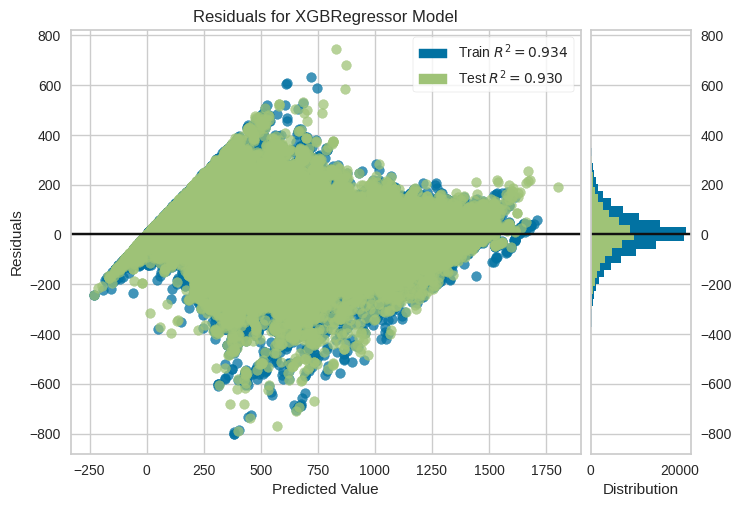

In [18]:
plot_model(best_model)

Above plot indicates that there is impact of outliers in the model. It can be seen far from Horizontal access.

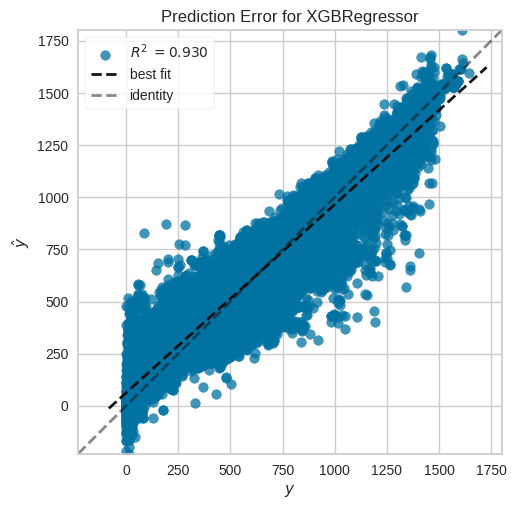

In [19]:
plot_model(best_model, plot='error')

Above plot shows that most of the prediction are close to regression line. It indicates the quality of model.

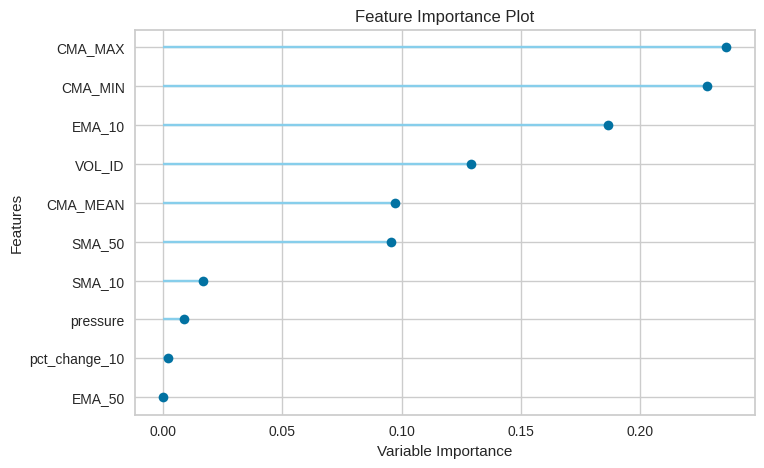

In [20]:
plot_model(best_model, plot='feature')

Feature Importance shows that EMA_50, pct_change_10 and pressure are least important features and  doesn't have much impact. pct_change_10 is just a change between 10 consecutive time stamp, so it make sense that it won't have much impact for predicting time to erupt.
MAE, MSE, RMSE and R2 can be further improved if we increased the window for moving averages, However those many data points would be required for prediction as well, that's why going with only 50 previous data points.

In [21]:
tuned_xgboost = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,56.5322,6933.3320,83.2666,0.9523,0.3603,0.3046
1,56.6749,6788.5806,82.3928,0.9539,0.3593,0.3110
2,57.1451,7034.8003,83.8737,0.9515,0.3714,0.3162
3,57.2458,7023.9580,83.8091,0.9514,0.3570,0.3139
4,56.9866,7189.8530,84.7930,0.9500,0.3687,0.3244
5,57.1275,7114.1704,84.3455,0.9502,0.3579,0.3019
6,56.4573,6975.6851,83.5206,0.9517,0.3549,0.3013
7,57.7951,7448.6738,86.3057,0.9486,0.3714,0.3211
8,58.2147,7387.2153,85.9489,0.9487,0.3550,0.2874


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


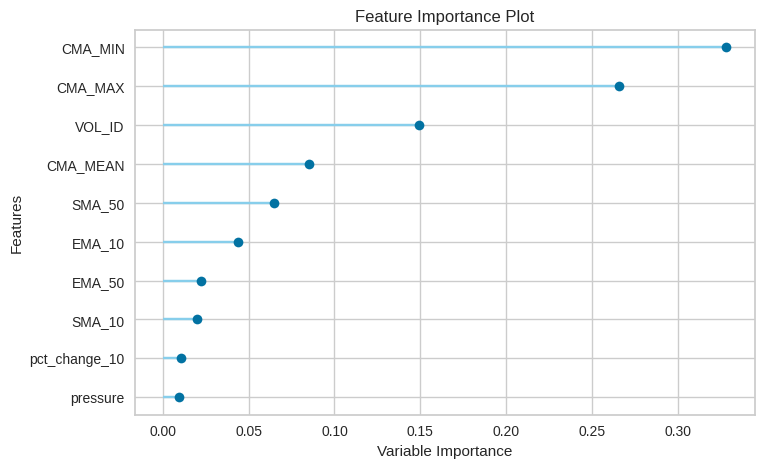

In [22]:
plot_model(tuned_xgboost,plot='feature')

** Retrying after removing least important features**

In [23]:
data = training_data.drop(columns=['ts','pct_change_10','pressure']).reset_index(drop=True)
exp_2 = setup(data=data, target='time_to_erupt',session_id=4220,fold_groups='VOL_ID', use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,4220
1,Target,time_to_erupt
2,Target type,Regression
3,Original data shape,"(190260, 9)"
4,Transformed data shape,"(190260, 9)"
5,Transformed train set shape,"(133182, 9)"
6,Transformed test set shape,"(57078, 9)"
7,Numeric features,7
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

In [24]:
xgboost_2 = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,72.5780,10015.8379,100.0792,0.9309,0.4279,0.4438
1,71.0074,9945.6035,99.7276,0.9319,0.4226,0.4214
2,72.8689,10396.3193,101.9623,0.9288,0.4483,0.4612
3,73.0713,10242.8496,101.2070,0.9284,0.4230,0.4323
4,73.1824,10336.2402,101.6673,0.9284,0.4346,0.4332
5,71.9490,10096.9541,100.4836,0.9294,0.4365,0.4319
6,71.7530,10137.5117,100.6852,0.9304,0.4507,0.4420
7,73.1696,10431.7275,102.1358,0.9285,0.4326,0.4309
8,70.9379,9843.7080,99.2155,0.9319,0.4405,0.4564


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
tuned_xgboost_2 = tune_model(xgboost_2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.7290,6303.8486,79.3968,0.9565,0.3464,0.3007
1,51.4828,6122.0796,78.2437,0.9581,0.3339,0.2744
2,52.3171,6361.3721,79.7582,0.9564,0.3575,0.3029
3,51.6360,6104.2114,78.1295,0.9573,0.3441,0.2892
4,51.7385,6130.4038,78.2969,0.9575,0.3400,0.2791
5,51.4992,6210.4756,78.8066,0.9566,0.3642,0.3120
6,52.6666,6515.3975,80.7180,0.9553,0.3659,0.3090
7,51.9819,6184.7002,78.6429,0.9576,0.3352,0.2715
8,51.0768,6136.1045,78.3333,0.9576,0.3593,0.3111


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


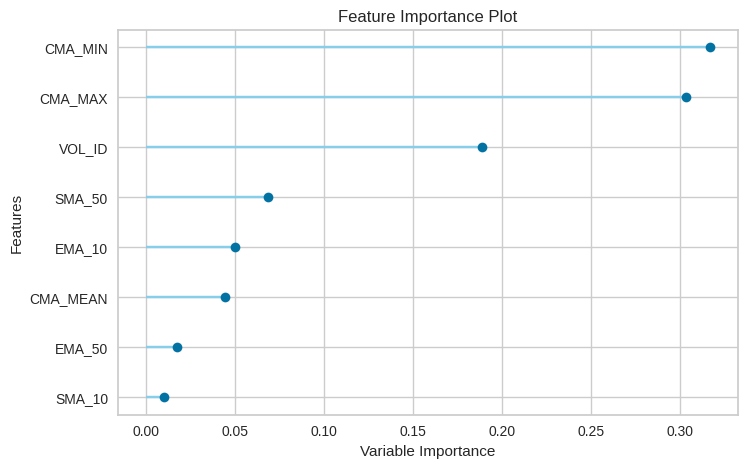

In [26]:
plot_model(tuned_xgboost_2,plot='feature')

In [27]:
result = predict_model(estimator=tuned_xgboost_2, data=unseen_data.drop(columns=['ts','pressure','pct_change_10']).reset_index(drop=True))
result

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,293.4148,142331.1250,377.2680,0.0874,0.9017,1.4644


,VOL_ID,SMA_10,SMA_50,CMA_MEAN,CMA_MIN,CMA_MAX,EMA_10,EMA_50,time_to_erupt,prediction_label
0,Volcano8_observation18,7.600116e-12,1.114119e-12,1.114119e-12,-7.256936e-10,6.408931e-10,8.692876e-11,8.692876e-11,1475.0,904.714966
1,Volcano8_observation18,4.246228e-11,-3.040138e-11,-3.040138e-11,-7.256936e-10,6.408931e-10,2.565003e-12,2.565003e-12,1474.0,1083.900391
2,Volcano8_observation18,-2.178366e-12,-3.861722e-11,-3.861722e-11,-7.256936e-10,6.408931e-10,-2.284813e-11,-2.284813e-11,1473.0,1133.098389
3,Volcano8_observation18,-1.098168e-10,-9.272572e-11,-9.272572e-11,-7.961362e-10,6.408931e-10,-1.634460e-10,-1.634460e-10,1472.0,963.978943
4,Volcano8_observation18,-5.043974e-11,-7.843014e-11,-7.843014e-11,-7.961362e-10,6.408931e-10,-1.115998e-10,-1.115998e-10,1471.0,950.997925
...,...,...,...,...,...,...,...,...,...,...
50672,Volcano10_observation12,7.481891e-10,3.618249e-11,7.786410e-12,-1.523482e-09,2.008466e-09,8.817999e-10,8.817999e-10,4.0,-90.735138
50673,Volcano10_observation12,1.077237e-09,8.978038e-11,9.675703e-12,-1.523482e-09,2.528103e-09,1.181128e-09,1.181128e-09,3.0,10.352716
50674,Volcano10_observation12,1.330346e-09,1.656698e-10,1.191820e-11,-1.523482e-09,3.003412e-09,1.512452e-09,1.512452e-09,2.0,-33.235977
50675,Volcano10_observation12,1.761724e-09,2.482160e-10,1.531224e-11,-1.523482e-09,4.546358e-09,2.064071e-09,2.064071e-09,1.0,-114.595764


# Pressure Prediction for Volcano
Here we want to predict the pressure for volcano over at a certain point in time based on its pressure history. Since we have data points from different volcano, it is required to use the data series from different volcanos to generalize the model for prediction, however at the same time, Sequence needs to be maintained.

In [28]:
from pycaret.time_series import *
vol_grp = final_df_time.groupby('VOL_ID')

In [29]:
train_volcanos = random.sample(vol_grp.groups.keys(),k=150)
unseen_volcanos = vol_grp.groups.keys()-train_volcanos
vol_1 = vol_grp.get_group(train_volcanos[0])[['pressure']].tail(1000)

In [30]:
print(train_volcanos)
print(unseen_volcanos)

['Volcano10_observation22', 'Volcano10_observation7', 'Volcano2_observation10', 'Volcano3_observation16', 'Volcano4_observation11', 'Volcano2_observation7', 'Volcano6_observation24', 'Volcano9_observation11', 'Volcano8_observation12', 'Volcano8_observation13', 'Volcano10_observation2', 'Volcano6_observation1', 'Volcano3_observation18', 'Volcano2_observation23', 'Volcano5_observation3', 'Volcano8_observation20', 'Volcano6_observation4', 'Volcano4_observation15', 'Volcano4_observation7', 'Volcano6_observation25', 'Volcano4_observation9', 'Volcano2_observation5', 'Volcano6_observation17', 'Volcano8_observation14', 'Volcano7_observation2', 'Volcano4_observation12', 'Volcano6_observation15', 'Volcano3_observation14', 'Volcano6_observation11', 'Volcano4_observation10', 'Volcano2_observation1', 'Volcano2_observation25', 'Volcano4_observation8', 'Volcano3_observation8', 'Volcano6_observation3', 'Volcano10_observation15', 'Volcano3_observation12', 'Volcano8_observation4', 'Volcano7_observation5

In [31]:
s = setup(data=vol_1,fh=15,target='pressure',fold_strategy='sliding',
transform_target='box-cox',fold=10)

,Description,Value
0,session_id,3073
1,Target,pressure
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1000, 1)"
5,Transformed data shape,"(1000, 1)"
6,Transformed train set shape,"(985, 1)"
7,Transformed test set shape,"(15, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,SlidingWindowSplitter


In [32]:
best_model_time = compare_models(fold=5)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ets,ETS,7474930918.8016,56854192.4574,0.8472,0.8472,60891641198.5272,2.0000,-67425137949908606976.0000,0.1860
exp_smooth,Exponential Smoothing,7477257735.0258,56871862.0896,0.8475,0.8475,60902853462.7414,2.0000,-67467711685321408512.0000,0.1240
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,7534066212.2818,63381917.3547,0.8537,0.9445,60841491292.6290,2.0000,-84466013810914721792.0000,0.7560
theta,Theta Forecaster,7820274129.1824,59484328.7426,0.8864,0.8864,62253929670.0359,2.0000,-74512458066075746304.0000,0.1800
arima,ARIMA,8252882490.4513,62782929.2739,0.9355,0.9355,66336719955.2160,2.0000,-82800583985369726976.0000,0.2200
grand_means,Grand Means Forecaster,8254951212.8782,62797353.0380,0.9358,0.9358,66336671888.6341,2.0000,-82835405308601991168.0000,0.1620
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,8442750918.6926,64224199.9173,0.9570,0.9570,68787537755.5942,2.0000,-86262180219052556288.0000,0.4400
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,8442751518.8182,64224204.0642,0.9570,0.9570,68787532974.1880,2.0000,-86262194871073931264.0000,0.4320
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,8442751518.8182,64224204.0642,0.9570,0.9570,68787532974.1880,2.0000,-86262194871073931264.0000,0.6680
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,8442751964.5246,64224206.9806,0.9570,0.9570,68787533366.1345,2.0000,-86262201427712180224.0000,0.4320


Processing:   0%|          | 0/109 [00:00<?, ?it/s]

None of the models are not looking very good. Also It is unclear to provide custom data to pycaret.
Also boxcox tranformation is not relaible from pycaret because some pressure values are negative.

In [33]:
plot_model(best_model_time,plot='forecast')

In [34]:
val = vol_grp.get_group(train_volcanos[0])
print(val.shape)
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
val_scaled = mms.fit_transform(val[['pressure']])
val_scaled.shape

(1403, 12)


(1403, 1)

In [35]:
from scipy.stats import boxcox
X_train_df = pd.DataFrame()
y_train_df = pd.DataFrame()
best_lambda = []
for group in train_volcanos:
  val = vol_grp.get_group(group).iloc[:,1:2]
  mms = MinMaxScaler()
  val_scaled = mms.fit_transform(val[['pressure']])
  # print(f'group name {group}, elements {len(val)}, {val.shape}')
  X_train = []
  y_train = []
  for i in range(500, len(val_scaled)):
    X_train.append(val_scaled[i-500:i].reshape(1,-1)[0])
    y_train.append(val_scaled[i:i+1].reshape(1,-1)[0])
  temp_df = pd.DataFrame(X_train)
  temp_df.columns = list(range(500))
  # temp_df['VOL_ID'] = group
  X_train_df  = pd.concat([X_train_df,temp_df],axis=0)
  y_train_df =  pd.concat([y_train_df,pd.DataFrame(y_train)],axis=0)


X_train_df.shape

(115745, 500)

In [36]:
print(X_train_df.shape)
print(y_train_df.shape)

(115745, 500)
(115745, 1)


In [37]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

In [38]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import math
from sklearn.metrics import mean_squared_error
tf.data.experimental.prefetch_to_device('GPU')

regressor = Sequential()
# First LSTM layer with drop out regularization
regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

#Second LSTM layer with dropout regularization
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

#Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

#Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

#Output later
regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

regressor.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
 856/3618 [======>.......................] - ETA: 50:44 - loss: 0.0058

KeyboardInterrupt: 

In [ ]:

y_df = pd.DataFrame()
for volcano in unseen_volcanos:
  val = vol_grp.get_group(volcano)
  mms = MinMaxScaler()
  x_test = mms.fit_transform(val[['pressure']])
  # print(f'group name {volcano}, elements {len(val)}, {val.shape}')
  y = regressor.predict(x_test)
  # print(y.shape)
  # plt.plot(mms.inverse_transform(y))

  predicted_y = mms.inverse_transform(y)
  val['predicted'] = pd.DataFrame(predicted_y)
  y_df = pd.concat([y_df,val[len(val)-1:]],axis=0)
# y_df['diff'] = (y['predicted'] - y['pressure'])*100/y['pressure']
y_df

In [ ]:
# tss = TimeSeriesSplit(n_splits=2)
# model = LinearRegression()
# features = ['pressure','pct_change','SMA','CMA','EMA']
# output = ['time_to_erupt']

# for grp_name in vol_grped.groups.keys():
#   train_df = vol_grped.get_group(grp_name)
#   X_train = train_df[features]
#   y_train = train_df[output]
#   mms = MinMaxScaler()
#   for train_index, valid_index in tss.split(train_df):
#       # print(f'train_index {train_index}, valid_index {valid_index}')
#       mms = MinMaxScaler()
#       train_x = mms.fit_transform(X_train.iloc[train_index])
#       valid_x = mms.transform(X_train.iloc[valid_index])
#       mms = MinMaxScaler()
#       train_y = mms.fit_transform(y_train.iloc[train_index])
#       valid_y = mms.transform(train_df[output].iloc[valid_index])
#       # print(f'Training shape {train_x.shape} y lable {train_y.shape}')
#       # # Train a linear regression model on the training data
#       model.fit(train_x, train_y)
#       # # Evaluate the model on the validation data
#       valid_pred = model.predict(valid_x)
#       print(f'Validation RMSE: {np.sqrt(mean_squared_error(valid_y, valid_pred))}')

In [ ]:
vol_grped = final_df_time.groupby('VOL_ID')


In [ ]:
# X_train_df = pd.DataFrame()
# y_train_df = pd.DataFrame()
# for group,val in final_df_time.groupby('VOL_ID'):
#   # print(f'group name {group}, elements {len(val)}, {val.shape}')
#   X_train = []
#   y_train = []
#   for i in range(100, len(val)):
#     X_train.append(val[i-100:i].iloc[:,1:2].values.reshape(1,-1)[0])
#     y_train.append(val[i:i+1].iloc[:,1:2].values.reshape(1,-1)[0])
#   temp_df = pd.DataFrame(X_train)
#   temp_df.columns = list(range(100))
#   temp_df['VOL_ID'] = group
#   X_train_df  = pd.concat([X_train_df,temp_df],axis=0)
#   y_train_df =  pd.concat([y_train_df,pd.DataFrame(y_train)],axis=0)


# X_train_df.shape

In [ ]:
# print(X_train_df.shape)
# print(y_train_df.shape)